Rozpoczynam od zaimportowania modułów, w tym Tensorflow działającego na GPU

In [1]:
from keras import layers
from keras import models
import numpy as np
import tensorflow as tf
import keras
import os
import shutil

# gpus = tf.config.list_physical_devices('GPU')
# if len(gpus) > 0: 
#    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

print("TensorFlow version: " + tf.__version__)
print("Keras version: " + keras.__version__)
print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)

print(tf.config.get_visible_devices())
# [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


TensorFlow version: 2.10.0
Keras version: 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
<function is_built_with_cuda at 0x000002D444915090>
/device:GPU:0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15058411882720421728
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 30294491136
locality {
  bus_id: 1
}
incarnation: 481657681839976484
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 15582073408
locality {
  bus_id: 1
}
incarnation: 15681336803217052046
physical_device_desc: "device: 1, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


In [6]:
# The path to store trained models
models_dir = 'C:/ml/models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = 'C:/ml/data/kaggle/original/train'

# The directory where we will store our smaller dataset
base_dir = 'C:/ml/data/kaggle/processed/cats_and_dogs_small'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)


In [57]:
from keras import layers
from keras import models
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import random
import math
import copy

img_rows = 150
img_cols = 150

def ListEqual(a, b):
    if len(a) != len(b):
        return False
    else:
        for i in range(len(a)):
            if isinstance(a[i], list) and isinstance(b[i], list):
                if not ListEqual(a[i], b[i]):
                    return False
            else:
                if isinstance(a[i], list) or isinstance(b[i], list):
                    return False
                else:
                    if a[i] != b[i]:
                        return False
    return True

def IsModelUnique(m_list, n_list, m_data):
    for m in m_list:
        data = m[5]
        if ListEqual(data, m_data):
            return False
    for n in n_list:
        if ListEqual(n, m_data):
            return False
    return True
    
def GetCombo(a, b, m_l, n_l):
    resultData = []
    print("\t", a)
    print("\t", b)
    for i in range(0, len(a)):
        if a[i] != b[i]:
            if isinstance(a[i], int):
                avg = int(round((a[i] + b[i]) / 2))
                m = a.copy()
                m[i] = avg
                if IsModelUnique(m_l, n_l, m):
                    resultData.append(m)
            else:
                m = a.copy()
                m[i] = b[i]
                if IsModelUnique(m_l, n_l, m):
                    resultData.append(m)
    print("\t\t", resultData)
    return resultData

def EvolveBest(inputShape, dataList, modelMakingFunction, nC, percentage, trainData, valData, ep, epochSteps, model_list, currentBest):
    print("data list:", dataList)
    # inputShape jest zawsze stałe, więc będzie osobne od listy
    newModelList = []
    for x in range(0, len(dataList)):
        model, name = modelMakingFunction(inputShape, dataList[x], nC)
        color = RandomColor()
        history = model.fit(
            trainData,
            steps_per_epoch=epochSteps,
            epochs=ep,
            validation_data=valData,
            validation_steps=math.ceil(epochSteps / 2))
        model_list.append([model, name, history, max(history.history['val_acc']), history.history['acc'][-1], dataList[x], color])
        newModelList.append([model, name, history, max(history.history['val_acc']), history.history['acc'][-1], dataList[x], color])
        print("Model", name, "trained")
    
    # Sortujemy listę modeli po wyniku walidacji
    model_list.sort(key=lambda x: x[3], reverse=True)
    newModelList.sort(key=lambda x: x[3], reverse=True)
    print(model_list)
    # Jeśli najnowszy najlepszy model nie jest lepszy od dotychczasowego o przynajmniej 5%, kończymy zabawę
    if newModelList[0][3] < currentBest * 1.05 or len(newModelList) < 2:
        return model_list
    else:
        goodData = []
        # maxAmount = math.ceil(percentage * len(dataList))
        for entry in model_list:
            if entry[3] > percentage * currentBest and len(goodData) < 3:
                    goodData.append(entry[5])

        newData = []
        if len(goodData) > 1:
            for i in range(0, len(goodData)):
                for j in range(0, len(goodData)):
                    if i != j:
                        print(goodData[i])
                        print(goodData[j])
                        newData += GetCombo(goodData[i], goodData[j], model_list, newData)
            print(newData)
        # Mamy dane które potrzebujemy, teraz należy przesłać do funkcji rekurencyjnie
        return EvolveBest(
            inputShape,
            newData, # dane z których mają być tworzone modele
            modelMakingFunction, # tutaj SimpleMaker
            nC,
            percentage,
            trainData,
            valData,
            ep,
            epochSteps,
            model_list,
            model_list[0][3])
        
def ModelMaker(i_sh, data):
    layerList = data[0]
    denseNeurons = data[1]
    activationF = data[2]
    opt = data[3]
    convAmount = 0
    poolAmount = 0

    model = models.Sequential()
    for l in layerList:
        if isinstance(l, list):
            if len(model.layers) == 0:
                model.add(layers.Conv2D(
                    l[0], (l[1], l[1]), activation=activationF, input_shape=i_sh))
                convAmount += 1
            else:
                model.add(layers.Conv2D(
                    l[0], (l[1], l[1]), activation=activationF))
                convAmount += 1
        else:
            model.add(layers.MaxPooling2D((l, l)))
            poolAmount += 1
    model.add(layers.Flatten())
    model.add(layers.Dense(denseNeurons, activation=activationF))
    model.add(layers.Dense(1, activation='sigmoid'))
    functionName = ""
    if isinstance(activationF, str):
        functionName = activationF
    else:
        functionName = "L_ReLU"
    optName = ""
    if isinstance(opt, str):
        optName = opt
    else:
        optName = "RMSprop"
    name = "Cnv:" + str(convAmount) + " MPl:" + str(poolAmount) + " dns:" + str(denseNeurons) + " " + functionName + " " + optName
    model.compile(loss='binary_crossentropy',
                  # optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                  optimizer=opt,
                  metrics=['acc'])
    return model, name

def SimpleMaker(i_sh, data, neuronIncreaseCutoff):
    layerCount = data[0]
    baseNeuronCount = 2 ** data[1]
    denseNeurons = 2 ** data[2]
    activationF = data[3]
    if activationF == 'leaky_relu':
        aF = tf.keras.layers.LeakyReLU(alpha=0.3)
    else:
        aF = activationF
    opt = data[4]

    model = models.Sequential()
    layerInfo = ""
    for i in range(0, layerCount):
        neur = 0
        if i < neuronIncreaseCutoff:
            neur = baseNeuronCount * (2 ** i)
        else:
            neur = baseNeuronCount * (2 ** neuronIncreaseCutoff)
        layerInfo += str(neur) + "-"
        if i == 0:
            model.add(layers.Conv2D(neur, (3, 3), activation=aF, input_shape=i_sh, padding='same'))
            model.add(layers.MaxPooling2D((2,2)))
        else:
            model.add(layers.Conv2D(neur, (3, 3), activation=aF, padding='same'))
            model.add(layers.MaxPooling2D((2,2)))
            
    model.add(layers.Flatten())
    model.add(layers.Dense(denseNeurons, activation=aF))
    model.add(layers.Dense(1, activation='sigmoid'))
    name = "L:" + layerInfo + " dns:" + str(denseNeurons) + " " + activationF + " " + opt
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['acc'])
    return model, name

def RandomColor():
    random_number = random.randint(0, 16777215)
    hex_number = str(hex(random_number))
    return '#' + f'{"%06x" % random.randint(0, 0xFFFFFF)}'


def PlotAccuracyComparison(m_list):
    plt.clf()
    plt.figure(figsize=(25, 5))
    for m in m_list:
        r_color = m[6]
        name = m[1]
        history = m[2]
        accuracy = history.history['acc']
        validation_accuracy = history.history['val_acc']
        epochs = range(len(accuracy))
        plt.plot(epochs, accuracy, 'o', label ='Training accuracy for ' + name, color=r_color)
        plt.plot(epochs, validation_accuracy, label ='Validation accuracy for ' + name, color=r_color)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()


def PlotLossComparison(m_list):
    plt.clf()
    plt.figure(figsize=(25, 5))
    for m in m_list:
        r_color = m[6]
        name = m[1]
        history = m[2]
        loss = history.history['loss']
        validation_loss = history.history['val_loss']
        epochs = range(len(loss))
        plt.plot(epochs, loss, 'o', label='Training loss for ' + name, color=r_color)
        plt.plot(epochs, validation_loss, label='Validation loss for ' + name, color=r_color)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()


In [ ]:
# This is module with image preprocessing utilities
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
img_rows = 150
img_cols = 150
shapeNow = (img_rows, img_cols, 3)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_rows, img_cols))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

In [64]:
modelData = [
    [
        5, 5, 8, 'leaky_relu',"rmsprop"
    ],
    [
        5, 5, 8, 'relu',"rmsprop"
    ],
    [
        3, 5, 8, 'relu', "rmsprop"
    ],
    [
        6, 5, 8, 'relu', "rmsprop"
    ],
    [
        5, 3, 8, 'relu', "rmsprop"
    ],
    [
        5, 7, 8, 'relu', "rmsprop"
    ],
    [
        5, 5, 6, 'relu',"rmsprop"
    ],
    [
        5, 5, 10, 'relu',"rmsprop"
    ],
    [
        5, 5, 8, 'relu',"adam"
    ],
    [
        5, 5, 8, 'relu',"sgd"
    ]
]
modelList = []

newList = EvolveBest(
    shapeNow,
    modelData,
    SimpleMaker,
    2, # Neuron Increase Cutoff
    0.9, # Percentage of required best
    train_generator,
    validation_generator,
    30,
    100,
    modelList,
    0)

data list: [[5, 5, 8, 'leaky_relu', 'rmsprop'], [5, 5, 8, 'relu', 'rmsprop'], [3, 5, 8, 'relu', 'rmsprop'], [6, 5, 8, 'relu', 'rmsprop'], [5, 3, 8, 'relu', 'rmsprop'], [5, 7, 8, 'relu', 'rmsprop'], [5, 5, 6, 'relu', 'rmsprop'], [5, 5, 10, 'relu', 'rmsprop'], [5, 5, 8, 'relu', 'adam'], [5, 5, 8, 'relu', 'sgd']]
Epoch 1/30
100/100 [==============================] - 10s 84ms/step - loss: 0.8208 - acc: 0.5220 - val_loss: 0.6912 - val_acc: 0.5390
Epoch 2/30
100/100 [==============================] - 8s 83ms/step - loss: 0.7800 - acc: 0.5690 - val_loss: 0.7021 - val_acc: 0.5160
Epoch 3/30
100/100 [==============================] - 8s 84ms/step - loss: 0.7161 - acc: 0.5735 - val_loss: 0.6543 - val_acc: 0.5910
Epoch 4/30
100/100 [==============================] - 8s 82ms/step - loss: 0.6684 - acc: 0.6175 - val_loss: 0.7534 - val_acc: 0.5930
Epoch 5/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6557 - acc: 0.6125 - val_loss: 0.6624 - val_acc: 0.6320
Epoch 6/30
100/100 [==

In [67]:
import pickle
# newList.save(models_dir + 'cats_and_dogs_all.h5')
with open("all.pkl", "wb") as f:
        pickle.dump(newList, f)

INFO:tensorflow:Assets written to: ram://5dfc166d-1dd6-4911-afbe-cd798f6dc156/assets


INFO:tensorflow:Assets written to: ram://5dfc166d-1dd6-4911-afbe-cd798f6dc156/assets


INFO:tensorflow:Assets written to: ram://63c0d35b-d3e7-4441-a342-e4e840e0eb6a/assets


INFO:tensorflow:Assets written to: ram://63c0d35b-d3e7-4441-a342-e4e840e0eb6a/assets


INFO:tensorflow:Assets written to: ram://6808d8b6-9854-49f7-8d45-7b51c0fba709/assets


INFO:tensorflow:Assets written to: ram://6808d8b6-9854-49f7-8d45-7b51c0fba709/assets


INFO:tensorflow:Assets written to: ram://b64b0f6e-05dd-4e82-a91d-92e10fb0c3a2/assets


INFO:tensorflow:Assets written to: ram://b64b0f6e-05dd-4e82-a91d-92e10fb0c3a2/assets


INFO:tensorflow:Assets written to: ram://59342d9f-0379-4cc6-a12b-0b8f5bb3f0a8/assets


INFO:tensorflow:Assets written to: ram://59342d9f-0379-4cc6-a12b-0b8f5bb3f0a8/assets


INFO:tensorflow:Assets written to: ram://e50874a6-9ddb-4131-91d6-9626b9a1a40f/assets


INFO:tensorflow:Assets written to: ram://e50874a6-9ddb-4131-91d6-9626b9a1a40f/assets


INFO:tensorflow:Assets written to: ram://044c15de-2c5e-4a83-82fd-97458c0a067c/assets


INFO:tensorflow:Assets written to: ram://044c15de-2c5e-4a83-82fd-97458c0a067c/assets


INFO:tensorflow:Assets written to: ram://0a287c8a-68b7-4c1d-b87d-45dcabf522ee/assets


INFO:tensorflow:Assets written to: ram://0a287c8a-68b7-4c1d-b87d-45dcabf522ee/assets


INFO:tensorflow:Assets written to: ram://31ad8716-e472-4400-9646-3bbc5425109b/assets


INFO:tensorflow:Assets written to: ram://31ad8716-e472-4400-9646-3bbc5425109b/assets


INFO:tensorflow:Assets written to: ram://153f0c83-9561-459d-8d11-c856c3098df8/assets


INFO:tensorflow:Assets written to: ram://153f0c83-9561-459d-8d11-c856c3098df8/assets


INFO:tensorflow:Assets written to: ram://2748b724-ff27-4819-a240-2e9d6e533cf8/assets


INFO:tensorflow:Assets written to: ram://2748b724-ff27-4819-a240-2e9d6e533cf8/assets


INFO:tensorflow:Assets written to: ram://89855e4e-4c22-4d32-a05e-033cbd7487a9/assets


INFO:tensorflow:Assets written to: ram://89855e4e-4c22-4d32-a05e-033cbd7487a9/assets


INFO:tensorflow:Assets written to: ram://87840d4e-08a9-4250-ab08-bb301f9e1129/assets


INFO:tensorflow:Assets written to: ram://87840d4e-08a9-4250-ab08-bb301f9e1129/assets


In [70]:
top3 = []
for i in range(0, 3):
    mod, nam = SimpleMaker(shapeNow, newList[i][5], 2)
    col = RandomColor()
    his = mod.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50)
    top3.append([mod, nam, his, max(his.history['val_acc']), his.history['acc'][-1], newList[i][5], col])
    mod.save(models_dir + 'cats_and_dogs_small_test' + str(i + 1) + '.h5')

top3.sort(key=lambda x: x[3], reverse=True)

Epoch 1/100
100/100 [==============================] - 9s 86ms/step - loss: 0.7999 - acc: 0.5310 - val_loss: 0.6868 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 9s 89ms/step - loss: 0.7055 - acc: 0.5495 - val_loss: 0.6765 - val_acc: 0.5350
Epoch 3/100
100/100 [==============================] - 9s 89ms/step - loss: 0.6893 - acc: 0.5945 - val_loss: 0.6583 - val_acc: 0.5670
Epoch 4/100
100/100 [==============================] - 9s 88ms/step - loss: 0.6706 - acc: 0.6065 - val_loss: 0.6398 - val_acc: 0.6140
Epoch 5/100
100/100 [==============================] - 9s 87ms/step - loss: 0.6596 - acc: 0.6350 - val_loss: 0.6093 - val_acc: 0.6880
Epoch 6/100
100/100 [==============================] - 9s 86ms/step - loss: 0.6339 - acc: 0.6605 - val_loss: 0.5991 - val_acc: 0.6960
Epoch 7/100
100/100 [==============================] - 9s 92ms/step - loss: 0.6425 - acc: 0.6395 - val_loss: 0.5600 - val_acc: 0.7230
Epoch 8/100
100/100 [==============================] - 9s 94ms

In [71]:
for i in range(0,3):
    top3[i][0].save(models_dir + 'cats_and_dogs_small_top' + str(i + 1) + '.h5')
with open("top3.pkl", "wb") as f:
        pickle.dump(top3, f)

INFO:tensorflow:Assets written to: ram://bcdb6398-c1fa-455f-9b1a-9aa03abf56fa/assets


INFO:tensorflow:Assets written to: ram://bcdb6398-c1fa-455f-9b1a-9aa03abf56fa/assets


INFO:tensorflow:Assets written to: ram://1fee0c82-bd7b-431c-878c-73a19aeb89c6/assets


INFO:tensorflow:Assets written to: ram://1fee0c82-bd7b-431c-878c-73a19aeb89c6/assets


INFO:tensorflow:Assets written to: ram://b8344a6b-c21a-4cc6-a174-c9406e40f072/assets


INFO:tensorflow:Assets written to: ram://b8344a6b-c21a-4cc6-a174-c9406e40f072/assets


<Figure size 432x288 with 0 Axes>

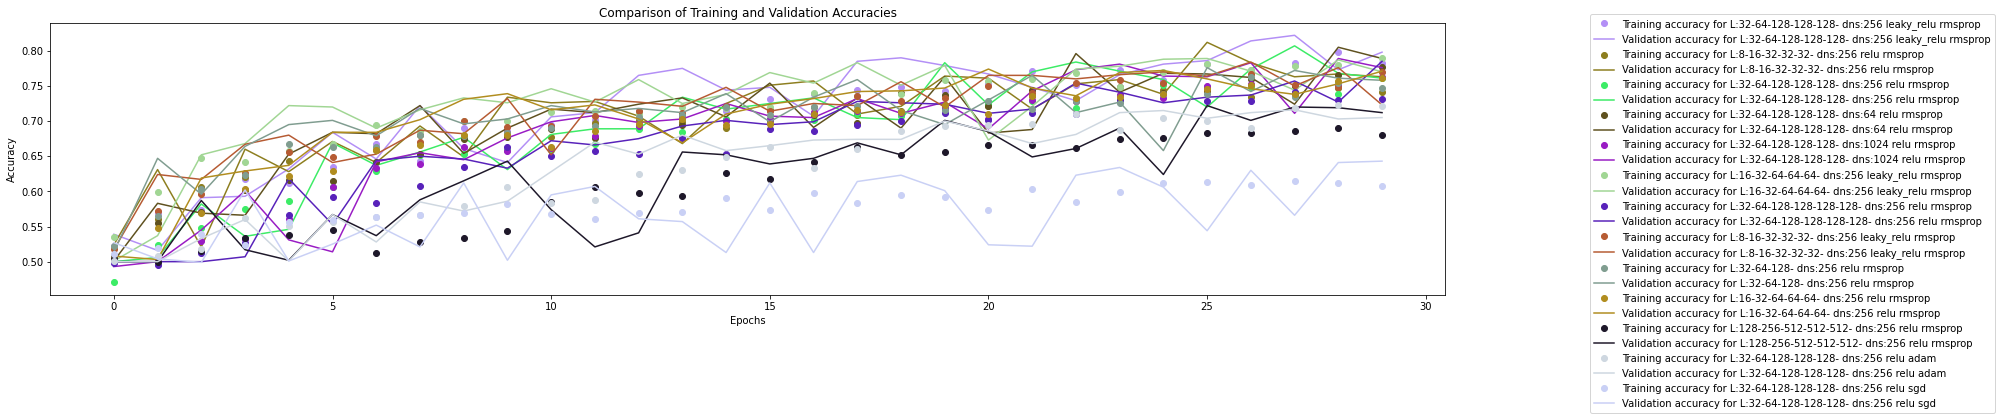

In [74]:
PlotAccuracyComparison(newList)

<Figure size 432x288 with 0 Axes>

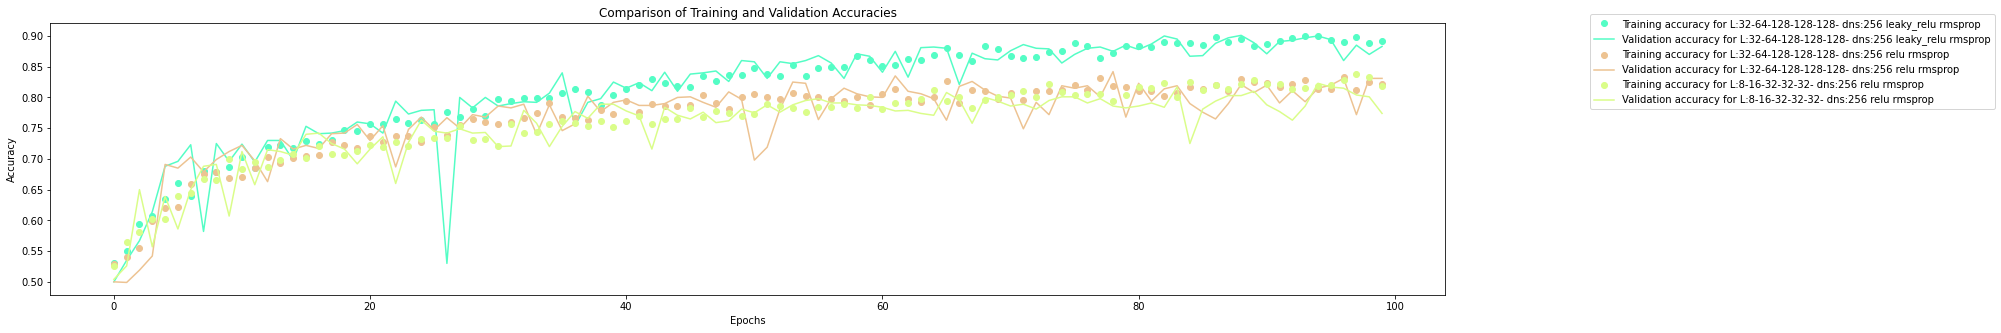

In [72]:
PlotAccuracyComparison(top3)

<Figure size 432x288 with 0 Axes>

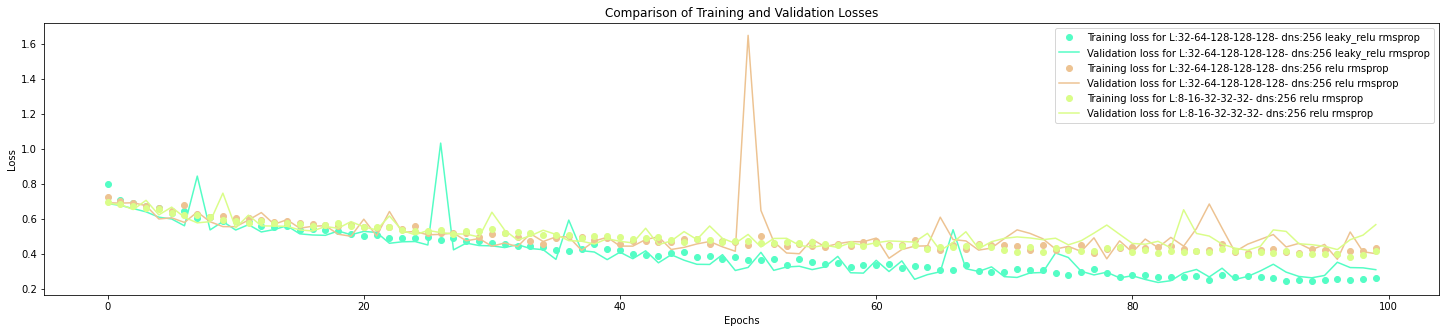

In [73]:
PlotLossComparison(top3)


# Wnioski
Najmocniej przepraszam za krótki i bezopisowy styl Lab 2 oraz Lab 3. Niestety sytuacja u mnie jest jaka jest (problemy z Tensorflow GPU oraz dziadek w szpitalu), więc miałem bardzo ograniczony czas. Postarałem się jednak wykonać coś, co przynajmniej zaprezentuje, że przeanalizowałem temat. Zezwolił mi Pan również na pracę tylko na datasecie Cats vs Dogs w celu oszczędności czasu.

W tym laboratorium zaprojektowałem system "genetycznej" ewolucji modeli, który dostaje zestaw początkowy danych, z których tworzy zestaw modeli, a następnie krzyżuje ze sobą najlepsze modele. Dzięki temu doszedłem do najlepszych 3 i je wytrenowałem już nie na 30, lecz na 100 epokach. Pozwoliło mi to osiągnąć model ze skutecznością około 90%. Jak widać najlepszym modelem był model standardowy z wyjątkiem zamiany funkcji ReLU na Leaky ReLU. Inne modele, które dobrze dopasowały się również były bliskie standardowemu napisanemu przez Profesora.

Niemniej jednak model z Leaky_ReLU pozwolił osiągnąć poważnie lepsze rezultaty od reszty modeli, tak więc będzie używany w Lab 3.